# Mammogram Lesion Classification with ConvNeXtV2 + Metadata Fusion

In this notebook, I implement and train a **binary classification model** to distinguish **malignant vs. benign breast lesions** using the **CBIS-DDSM dataset**.  
The approach combines **YOLO-generated lesion crops** with **exam-level metadata** (laterality and view indicators), leveraging a modern **ConvNeXtV2-Tiny** backbone fine-tuned for this task.

---

### **Motivation**
Accurate and robust classification of mammographic lesions is critical for computer-aided diagnosis (CAD) systems.  
My goal is to build a model that not only achieves strong overall AUC but also maintains **high sensitivity** (low false-negative rate), which is crucial for early cancer detection.

---

### **Approach**
1. **Data Preparation**  
   - Load pre-extracted lesion crops from YOLO detection results.  
   - Incorporate binary metadata features: `laterality_LEFT`, `laterality_RIGHT`, `view_CC`, and `view_MLO`.  
   - Apply extensive **augmentation** (CLAHE, color jitter, crop/flip, noise) for better generalization.

2. **Model Architecture**  
   - Base encoder: **ConvNeXtV2-Tiny** pretrained on ImageNet-22k.  
   - Concatenate learned image features with metadata vector.  
   - Final classifier: 2-layer MLP with dropout, bias initialized with log-odds of positive class.

3. **Training Strategy**  
   - **Hybrid loss:** Focal loss (to handle class imbalance) + BCE.  
   - **WeightedRandomSampler** to balance malignant vs. benign samples.  
   - **Warmup + Cosine LR Scheduler** with AdamW optimizer.  
   - Mixed precision training (AMP) for faster convergence.

4. **Evaluation & Analysis**  
   - Metrics: Accuracy, F1, AUC, MCC, Sensitivity, Specificity.  
   - Threshold optimization to maximize F1-score.  
   - Visualization: ROC/PR curves, confusion matrix, training history.  
   - Model interpretability: **Grad-CAM++** heatmaps & **SHAP** attributions (for both pixels and metadata).

---

### **Expected Outcomes**
By combining a strong image backbone with auxiliary metadata and careful training,  
I aim to achieve:
- **High AUC (>0.85)** and strong F1 score.
- **Sensitivity-first operating point**, minimizing missed malignancies.
- Meaningful, human-interpretable visual explanations to support trust in predictions.


In [1]:
# ===========================================
# 1 — Setup & Imports
# ===========================================
import os, random, time, platform, math, logging, warnings
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    classification_report, matthews_corrcoef
)

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger("timm").setLevel(logging.WARNING)


c:\Users\PC\anaconda3\envs\mammo-xai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


## Configuration

In this cell, I define the **paths**, **hyperparameters**, and **runtime settings** used throughout the notebook.

- **Paths**  
  `CSV_PATH` points to the YOLO crops metadata (relative paths + labels).  
  `ROOT_DIR` is used to resolve image paths on disk.

- **Hyperparameters**  
  - `IMG_SIZE = 448`: balances detail and speed for ConvNeXtV2-Tiny.  
  - `BATCH_SIZE = 16`, `EPOCHS = 15`: fast, iterative training; adjust for final runs.  
  - `LR = 1e-4`, `WEIGHT_DECAY = 1e-4`: stable defaults for AdamW + cosine schedule.  
  - `OUT_PATH`: where I save the best checkpoint (by validation AUC).

- **Reproducibility**  
  I seed Python, NumPy, and PyTorch (CPU + CUDA) with `SEED = 42` to reduce run-to-run variance.

- **Normalization**  
  I use standard **ImageNet** mean/std (`IMAGENET_MEAN`, `IMAGENET_STD`) to match the ConvNeXtV2 pretraining.

- **Runtime**  
  I auto-detect GPU/CPU (`DEVICE`) and print the CUDA status.  
  `IS_WIN` flags Windows so I can set `num_workers=0` later to avoid multiprocessing issues.


In [2]:
# ===========================================
# 2 — Config (fast defaults)
# ===========================================

# Paths to labels/crops:
# - CSV_PATH points to a CSV with columns like: yolo_cropped_image_path, label, laterality_*, view_*
# - ROOT_DIR is the root folder used to resolve those relative image paths.
CSV_PATH  = r"C:\Users\PC\Desktop\final project\CBIS-DDSM\calc\data\yolo_crops.csv"
ROOT_DIR  = r"C:\Users\PC\Desktop\final project\CBIS-DDSM\calc"

# Core hyperparameters
IMG_SIZE     = 448        # Good trade-off for ConvNeXtV2-Tiny;
BATCH_SIZE   = 16         # Increase if you have more VRAM; decrease if OOM
EPOCHS       = 15         # Short run for iteration; extend for final training
LR           = 1e-4       # AdamW base LR (works well with cosine schedule)
WEIGHT_DECAY = 1e-4       # Regularization for better generalization
OUT_PATH     = "models/convnextv2_tiny_cbis.pt"  # Checkpoint destination

# Reproducibility: seed all RNGs that matter
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Device & normalization
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # Standard ImageNet mean
IMAGENET_STD  = [0.229, 0.224, 0.225]  # Standard ImageNet std
IS_WIN = os.name == "nt" or "windows" in platform.system().lower()  # For num_workers handling

# Quick visibility: confirm device and CUDA availability
print("Device:", DEVICE, "| CUDA:", torch.cuda.is_available())


Device: cuda | CUDA: True


## Data Loading & Augmentation

In this step, I prepare the **dataset** and define the **transformations** applied to each image:

- **DataFrame Setup**  
  - Load YOLO-generated crop metadata from CSV.  
  - Remove missing files to avoid runtime errors.  
  - Convert `label` column to integer (0 = benign, 1 = malignant).  
  - Print class counts for transparency and imbalance analysis.

- **Augmentations**  
  - **Training pipeline:** Strong augmentations (CLAHE, brightness/contrast jitter, crop/flip, noise, rotation) to improve generalization.  
  - **Validation pipeline:** Deterministic preprocessing (CLAHE + resize) for unbiased evaluation.

- **Custom Dataset Class**  
  - Each item returns `(image_tensor, label, metadata)` where metadata encodes laterality & view type.  
  - Grayscale images are expanded to 3-channel RGB to match ConvNeXt’s expected input.

- **Sanity Check**  
  I verify that one transformed image has shape **(3, IMG_SIZE, IMG_SIZE)** — confirming correct preprocessing.

This step ensures the pipeline is **robust, reproducible, and ready for model training**.


In [3]:
# ===========================================
# 3 — DataFrame & Transforms (with sanity checks)
# ===========================================

# Load YOLO crops metadata (contains image paths + labels + metadata)
df = pd.read_csv(CSV_PATH)

# Verify that each cropped image path actually exists on disk
df["exists"] = df["yolo_cropped_image_path"].apply(
    lambda rel: os.path.exists(os.path.join(ROOT_DIR, str(rel).replace("\\", os.sep)))
)

# Keep only rows with existing files
df = df[df["exists"]].copy()

# Ensure labels are integers (0 = benign, 1 = malignant)
df["label"] = df["label"].astype(int)

# Print basic dataset stats
print(f"Samples: {len(df)} | Malignant: {(df['label']==1).sum()} | Benign: {(df['label']==0).sum()}")

# ---------------------------
# Data Augmentation Pipelines
# ---------------------------

# Training transforms: strong augmentations to improve robustness
train_tf = A.Compose([
    A.CLAHE(clip_limit=3.0, tile_grid_size=(8,8), p=1.0),         # Enhance local contrast
    A.RandomBrightnessContrast(0.15, 0.25, p=0.5),                # Vary illumination
    A.GaussianBlur(blur_limit=(3,5), p=0.15),                     # Mild blur for invariance
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.9, 1.0),
                        ratio=(0.9, 1.1), p=1.0),                 # Random crop + resize
    A.HorizontalFlip(p=0.5),                                     # Mirror symmetry
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.10,
                       rotate_limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.5),
    A.GaussNoise(var_limit=(5,20), p=0.15),                      # Low-level noise injection
    A.Normalize(IMAGENET_MEAN, IMAGENET_STD),                    # Normalize to ImageNet stats
    ToTensorV2(),                                                # Convert to PyTorch tensor
])

# Validation transforms: minimal, deterministic preprocessing
val_tf = A.Compose([
    A.CLAHE(clip_limit=3.0, tile_grid_size=(8,8), p=1.0),        # Contrast enhancement
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),                   # Fixed resize
    A.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ToTensorV2(),
])

# ---------------------------
# Custom Dataset Class
# ---------------------------

class CropsDataset(Dataset):
    def __init__(self, df, root=ROOT_DIR, tf=None):
        self.df, self.root, self.tf = df.reset_index(drop=True), root, tf

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        # Construct absolute path and load image as grayscale
        p = os.path.join(self.root, str(row["yolo_cropped_image_path"]).replace("\\", os.sep))
        im = Image.open(p).convert("L")
        arr = np.array(im)
        # Convert grayscale → RGB (3-channel) for ConvNeXt
        if arr.ndim == 2:
            arr = np.stack([arr, arr, arr], axis=2)
        arr = arr.astype(np.uint8)
        # Apply augmentations
        x = self.tf(image=arr)["image"]
        # Get label and exam-level metadata
        y = torch.tensor(int(row["label"]), dtype=torch.float32)
        meta = torch.tensor([
            int(row["laterality_LEFT"]),
            int(row["laterality_RIGHT"]),
            int(row["view_CC"]),
            int(row["view_MLO"]),
        ], dtype=torch.float32)
        return x, y, meta

# ---------------------------
# Sanity check: verify shape
# ---------------------------

sample_p = os.path.join(ROOT_DIR, str(df.iloc[0]["yolo_cropped_image_path"]).replace("\\", os.sep))
img = Image.open(sample_p).convert("L")
arr = np.stack([np.array(img)]*3, axis=2).astype(np.uint8)
xt = val_tf(image=arr)["image"]
print("One sample tensor shape:", tuple(xt.shape))
assert xt.shape[0] == 3 and xt.shape[1] == IMG_SIZE and xt.shape[2] == IMG_SIZE, "Transform shape mismatch!"


Samples: 1609 | Malignant: 442 | Benign: 1167
One sample tensor shape: (3, 448, 448)


## Train/Validation Split & DataLoaders

Here, I prepare the data for training by splitting, balancing, and batching it:

- **Stratified Split**  
  I use `train_test_split(..., stratify=label)` to maintain the same benign/malignant ratio in both training and validation sets.  
  Validation size = **20%** of dataset.

- **Custom Datasets**  
  Both `train_ds` and `val_ds` use the `CropsDataset` class defined earlier, but with different transform pipelines (augmentations vs. deterministic preprocessing).

- **Class Imbalance Handling**  
  I compute **inverse frequency weights** and pass them to a `WeightedRandomSampler`.  
  This ensures malignant cases are sampled more often (balanced minibatches), preventing the model from being biased toward the majority (benign) class.

- **DataLoaders**  
  - `train_loader`: uses sampler instead of shuffle for balanced training.  
  - `val_loader`: uses a larger batch size (2×) and no shuffling for deterministic validation.  

- **Sanity Checks**  
  I fetch one training batch to confirm:
  - Image tensor shape: **(B, 3, IMG_SIZE, IMG_SIZE)**  
  - Metadata tensor shape: **(B, 4)**  

This step ensures that the training pipeline is ready, balanced, and reproducible.


In [4]:
# ===========================================
# 4 — Splits & DataLoaders (with checks)
# ===========================================

# 1) Train/validation split (stratified to preserve class ratios)
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=SEED
)

# 2) Dataset objects with proper transforms
train_ds = CropsDataset(train_df, tf=train_tf)
val_ds   = CropsDataset(val_df, tf=val_tf)

# 3) WeightedRandomSampler to handle class imbalance
class_counts = Counter(train_df["label"].tolist())
weights = {c: len(train_df) / class_counts[c] for c in class_counts}  # inverse frequency
sample_weights = torch.tensor(train_df["label"].map(weights).values, dtype=torch.float32)

sampler = WeightedRandomSampler(
    sample_weights,
    num_samples=len(sample_weights),
    replacement=True  # enables balanced sampling
)

# 4) DataLoaders (batching, shuffling handled by sampler)
num_workers = 0 if IS_WIN else 4  # Windows needs 0 workers to avoid issues
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, sampler=sampler,
    num_workers=num_workers, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE*2, shuffle=False,
    num_workers=num_workers, pin_memory=True
)

# 5) Quick sanity check: inspect one batch
xb, yb, mb = next(iter(train_loader))
print("Batch:", xb.shape, yb.shape, mb.shape)

# Assert shapes to catch preprocessing issues early
assert xb.shape[1:] == (3, IMG_SIZE, IMG_SIZE), "Loader image shape mismatch!"
assert mb.shape[1] == 4, "Metadata dim mismatch!"


Batch: torch.Size([16, 3, 448, 448]) torch.Size([16]) torch.Size([16, 4])


## Model: ConvNeXtV2-Tiny with Metadata Fusion & Prior-Bias Initialization

**Goal.** Combine strong image features with simple exam metadata to improve malignancy prediction.

### Architecture
- **Backbone:** `ConvNeXtV2-Tiny` (pretrained on ImageNet-22k and fine-tuned on 1k), used as a **feature extractor** (`num_classes=0`, `global_pool="avg"`).  
- **Metadata:** 4 binary indicators — `laterality_LEFT`, `laterality_RIGHT`, `view_CC`, `view_MLO`.  
- **Fusion:** Concatenate pooled image features with the metadata vector, then pass through a **2-layer MLP (512 units, ReLU, Dropout)** to produce a **single logit**.

### Class-Prior Bias Initialization
To avoid poor calibration at the start of training, I initialize the final layer’s bias to the **log-odds** of the positive class estimated on the training split:

$$
p = \frac{\text{count of malignant samples}}{\text{count of malignant} + \text{count of benign}}
$$

$$
\text{bias}_0 = \log\!\left(\frac{p}{1 - p}\right)
$$

This makes the initial sigmoid output close to the empirical prior \(p\), stabilizing the early steps (especially under class imbalance).

### Why Metadata Fusion?
Mammography views and laterality are clinically informative. Concatenating them with image features is a simple, effective inductive bias that can:
- Improve discrimination in ambiguous visual cases,
- Help the model disambiguate **CC** vs **MLO** appearances,
- Provide slight calibration benefits without complicating the architecture.

### Sanity Check
I run a single forward pass on a training batch and print:
- Output shape (should be **(B, 1)**),
- Estimated positive prior \(p\),
- The computed **bias** \( \text{logit}(p) \).

This confirms the wiring is correct before training.


In [5]:
# ===========================================
# 5 — ConvNeXtV2-Tiny + metadata fusion + prior-bias init
# ===========================================

# --- Class prior & bias initialization (log-odds) ---
# Count positives/negatives in the TRAIN split to estimate p = P(y=1).
pos = int((train_df["label"] == 1).sum())
neg = int((train_df["label"] == 0).sum())
pos_prior = pos / max(1, (pos + neg))  # empirical positive rate in train set

# Initialize the final classifier bias to the log-odds of the positive class:
# bias_init = log(p / (1 - p)).
# This helps stabilize early training by matching the starting sigmoid output to the class prior.
bias_init = math.log(pos_prior / max(1e-8, (1 - pos_prior)))  # logit(p)

class ConvNeXtV2TinyWithMeta(nn.Module):
    def __init__(self, meta_dim=4, dropout=0.4, prior_bias=0.0):
        super().__init__()
        # Image backbone: ConvNeXtV2-Tiny, pretrained (IN-22k → IN-1k), no classifier head.
        self.base = timm.create_model(
            "convnextv2_tiny.fcmae_ft_in22k_in1k",
            pretrained=True, in_chans=3, num_classes=0, global_pool="avg"
        )
        feat_dim = self.base.num_features  # pooled feature size from backbone

        # (Optional) metadata normalization layer; Identity here but can swap for LayerNorm/BatchNorm if needed
        self.meta_norm = nn.Identity()

        # Fusion head: concat[image_feats, metadata] → MLP → 1 logit
        self.head = nn.Sequential(
            nn.Linear(feat_dim + meta_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(512, 1)
        )

        # Initialize the final bias to class-prior log-odds
        with torch.no_grad():
            self.head[-1].bias.fill_(prior_bias)

    def forward(self, x, meta):
        # x: (B, 3, H, W) images; meta: (B, meta_dim) metadata vector
        feats = self.base(x)                 # (B, feat_dim) global average pooled features
        meta  = self.meta_norm(meta)         # (B, meta_dim)
        fused = torch.cat([feats, meta], 1)  # (B, feat_dim + meta_dim)
        return self.head(fused)              # (B, 1) raw logit

def make_model(prior_bias):
    return ConvNeXtV2TinyWithMeta(meta_dim=4, prior_bias=prior_bias)

# Instantiate and quick forward sanity check
model = make_model(bias_init).to(DEVICE)
with torch.no_grad():
    out = model(xb.to(DEVICE), mb.to(DEVICE))
print("Forward OK — output:", tuple(out.shape), "| pos_prior≈", round(pos_prior, 4), "bias≈", round(bias_init, 3))


Forward OK — output: (16, 1) | pos_prior≈ 0.2751 bias≈ -0.969


##  Loss, Optimization, and Scheduling

I use a **hybrid loss** and a **warmup+cosine** learning-rate schedule with **mixed precision** to make training stable and efficient.

### Focal Loss (with BCE)
To address class imbalance and hard examples, I combine **Focal Loss** and **BCE**:

$$
\text{BCE}(z, y) = -\big[y \log \sigma(z) + (1-y)\log(1-\sigma(z))\big]
$$

$$
p_t =
\begin{cases}
\sigma(z), & y=1 \\
1-\sigma(z), & y=0
\end{cases}
\quad\quad
\text{Focal}(z,y) = \alpha \,(1-p_t)^{\gamma}\, \text{BCE}(z,y)
$$

My training objective is:

$$
\mathcal{L} = 0.5\cdot \text{Focal}(z,y) + 0.5\cdot \text{BCE}(z,y)
$$

- **Why hybrid?** Early in training, pure focal can be noisy; mixing with BCE stabilizes optimization while still emphasizing hard/rare positives.

### Optimizer
- **AdamW** with `lr = 1e-4` and `weight_decay = 1e-4` — standard, well-behaved defaults for ConvNeXt-type backbones.

### Learning-Rate Schedule
I use a **2-epoch linear warmup** followed by **cosine annealing**:

- Warmup helps avoid divergence when the head is randomly initialized.
- Cosine gently reduces LR, often improving final AUC without manual step tuning.

### Mixed Precision (AMP)
- `autocast` + `GradScaler` enable faster training and lower VRAM while keeping numerics stable on GPU.
- AMP is toggled automatically based on `DEVICE`.

This setup consistently yields **stable convergence** and **good generalization** on CBIS-DDSM with metadata fusion.


In [6]:
# ===========================================
# 6 — Loss, Optimizer, Warmup+Cosine Scheduler (AMP-safe)
# ===========================================

def focal_loss(inputs, targets, alpha=0.8, gamma=2.0, reduction='mean'):
    """
    Focal loss for binary classification with logits.
    - inputs: raw logits, shape (B, 1)
    - targets: {0,1} labels, shape (B, 1) or (B,)
    - alpha:   class weighting factor (down-weights easy negatives)
    - gamma:   focusing parameter (emphasizes hard samples)
    """
    # BCE on logits without reduction so we can reweight per-sample
    bce = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

    # Convert logits -> probabilities
    probs = torch.sigmoid(inputs)

    # p_t = p if y=1 else (1-p) if y=0
    p_t = probs * targets + (1 - probs) * (1 - targets)

    # Focal modulating factor: alpha * (1 - p_t)^gamma
    loss = (alpha * (1 - p_t) ** gamma) * bce

    return loss.mean() if reduction == 'mean' else loss.sum()

# Hybrid objective: 0.5 * Focal + 0.5 * BCE (stabilizes training early, still focuses on hard examples)
criterion = lambda logits, y: 0.5 * focal_loss(logits, y) + 0.5 * nn.functional.binary_cross_entropy_with_logits(logits, y)

# AdamW is robust for ViT/ConvNeXt-style backbones
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# LR schedule: short linear warmup → cosine decay over remaining epochs
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
WARMUP_EPOCHS = 2
scheduler = SequentialLR(
    optimizer,
    schedulers=[
        LinearLR(optimizer, start_factor=0.2, end_factor=1.0, total_iters=WARMUP_EPOCHS),     # warmup (20% → 100% LR)
        CosineAnnealingLR(optimizer, T_max=max(1, EPOCHS - WARMUP_EPOCHS))                    # cosine decay
    ],
    milestones=[WARMUP_EPOCHS]
)

# Automatic Mixed Precision (AMP): faster training, lower VRAM; safe scaler + autocast context
from torch import amp
use_cuda = (DEVICE.type == "cuda")
scaler = amp.GradScaler(enabled=use_cuda)
autocast_ctx = amp.autocast(device_type="cuda", enabled=use_cuda)

# Ensure output directory exists for checkpoints
os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)


## Evaluation Utilities

Before training, I define utility functions to quickly assess model performance on validation data.

### `evaluate(model, loader)`
- Runs inference on an entire dataloader under `torch.no_grad()` (no gradient computation → faster, less memory).
- Collects:
  - **True labels** (`y_true`)
  - **Predicted probabilities** (`y_prob`)
  - **Predicted labels** (`y_pred`, using fixed 0.5 threshold)
- Computes **key metrics**:
  - **Accuracy**
  - **F1-score**
  - **ROC AUC**

Returns both the metrics and raw arrays for later use (ROC curve plotting, threshold tuning).

### `print_val_report(model, loader)`
- Convenience wrapper: calls `evaluate` and prints results in a human-readable format.

### Sanity Check
I run a quick pass with the **randomly initialized model**.  
This should give:
- Accuracy ≈ 50% (near random guessing),
- F1 low, AUC ≈ 0.5.

This confirms the evaluation pipeline is working correctly **before training starts**.


In [7]:
# ===========================================
# 7 — Eval utilities (fast & detailed)
# ===========================================

@torch.no_grad()  # disable gradient tracking for faster inference & lower memory
def evaluate(model, loader, device=DEVICE):
    """
    Run full-dataset evaluation and compute key metrics.
    Returns:
        acc, f1, auc, (y_true, y_prob, y_pred)
    """
    model.eval()  # switch to eval mode (disable dropout, freeze batchnorm stats)
    y_true, y_prob = [], []

    # Iterate over validation dataloader
    for x, y, m in loader:
        # Move to device (GPU/CPU)
        x, y, m = x.to(device), y.to(device), m.to(device)

        # Forward pass → logits
        logits = model(x, m)

        # Convert to probabilities (sigmoid) and move to CPU for numpy metrics
        probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()
        y_prob.extend(probs)
        y_true.extend(y.cpu().numpy())

    # Convert probs to hard labels with fixed threshold 0.5
    y_pred = [1 if p >= 0.5 else 0 for p in y_prob]

    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    return acc, f1, auc, (y_true, y_prob, y_pred)


def print_val_report(model, loader, title="Validation @0.5"):
    """
    Convenience function: evaluate model and print a concise report.
    """
    acc, f1, auc, (y_true, y_prob, y_pred) = evaluate(model, loader)
    print(f"{title}: acc={acc:.4f} | f1={f1:.4f} | auc={auc:.4f}")
    return auc


# Quick smoke test: sanity check with random-initialized weights
_ = print_val_report(model, val_loader, title="Sanity check (random-ish weights)")


Sanity check (random-ish weights): acc=0.7267 | f1=0.0000 | auc=0.4225


## Training Loop (Epoch-wise)

This block performs the **core model training** and logs results every epoch.

### Steps per Epoch
1. **Training Phase**
   - Switch model to `train()` mode (enables dropout & batchnorm updates).
   - Iterate over training batches:
     - Forward pass under `autocast` (mixed precision for speed & memory).
     - Compute hybrid loss (Focal + BCE).
     - Backward pass & optimizer update (scaled if CUDA AMP is enabled).
   - Accumulate batch losses to compute **mean training loss**.

2. **Validation Phase**
   - After each epoch, evaluate on the validation set using `print_val_report`.
   - Report **accuracy, F1, and AUC @ threshold 0.5**.

3. **Learning-Rate Scheduler**
   - Step the scheduler to apply warmup or cosine decay.

4. **Logging & Tracking**
   - Print epoch summary with:
     - Training loss
     - Validation AUC
     - Current learning rate
     - Wall-clock time per epoch
   - Store metrics in `history` for later plotting (loss curve, AUC curve).

5. **Checkpointing**
   - If current epoch’s AUC > best seen so far:
     - Save model weights to `OUT_PATH`
     - Update `best_auc`

### Notes
- **Best model checkpointing** ensures we keep the highest-AUC model, not necessarily the last one.
- **Validation AUC** is used as the main criterion because it is threshold-independent and robust to class imbalance.
- **Mixed Precision Training (AMP)** accelerates training significantly on modern GPUs and reduces memory consumption.

This loop gives me a **reproducible, trackable training process** and a reliable best model for final evaluation.


In [8]:
# ===========================================
# 8 — Training Loop (fast, logs every epoch)
# ===========================================

from time import perf_counter
best_auc, history = -1.0, []  # track best AUC for checkpointing; store metrics per epoch

for epoch in range(1, EPOCHS+1):
    model.train()  # enable dropout, batchnorm updates
    t0 = perf_counter()
    total_loss, n = 0.0, 0  # running loss sum, number of samples

    # ---- Training step ----
    for x, y, m in train_loader:
        x, y, m = x.to(DEVICE), y.to(DEVICE).unsqueeze(1), m.to(DEVICE)

        # Clear gradients for this step
        optimizer.zero_grad(set_to_none=True)

        # Forward + loss (with AMP autocasting for speed/memory)
        with autocast_ctx:
            logits = model(x, m)
            loss = criterion(logits, y)

        # Backpropagation + optimizer step
        if use_cuda:
            # Scaled loss backward for AMP stability
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        # Track training loss (sum over batch)
        bs = x.size(0)
        total_loss += loss.item() * bs
        n += bs

    # ---- End of epoch: compute mean loss ----
    tr_loss = total_loss / max(1, n)

    # ---- Validation ----
    auc_epoch = print_val_report(model, val_loader, title=f"Epoch {epoch:02d} validation @0.5")

    # Update LR scheduler
    scheduler.step()

    # Log timing and learning rate
    dt = perf_counter() - t0
    lr_cur = optimizer.param_groups[0]['lr']

    # Save history for plotting later
    history.append({"epoch": epoch, "loss": tr_loss, "auc": auc_epoch})

    # Display summary
    print(f"Epoch {epoch:02d}: loss={tr_loss:.4f} | auc={auc_epoch:.4f} | lr={lr_cur:.2e} | time={dt:.1f}s")

    # ---- Checkpoint if AUC improved ----
    if auc_epoch > best_auc:
        best_auc = auc_epoch
        torch.save({"model": model.state_dict()}, OUT_PATH)
        print(f"  ↳ New best AUC {best_auc:.4f} — checkpoint saved to {OUT_PATH}")

print("Best AUC during training:", best_auc)


Epoch 01 validation @0.5: acc=0.7578 | f1=0.5357 | auc=0.7854
Epoch 01: loss=0.3934 | auc=0.7854 | lr=6.00e-05 | time=153.6s
  ↳ New best AUC 0.7854 — checkpoint saved to models/convnextv2_tiny_cbis.pt
Epoch 02 validation @0.5: acc=0.7267 | f1=0.5510 | auc=0.7345
Epoch 02: loss=0.3672 | auc=0.7345 | lr=1.00e-04 | time=152.2s
Epoch 03 validation @0.5: acc=0.7453 | f1=0.6204 | auc=0.8139
Epoch 03: loss=0.3436 | auc=0.8139 | lr=9.85e-05 | time=154.3s
  ↳ New best AUC 0.8139 — checkpoint saved to models/convnextv2_tiny_cbis.pt
Epoch 04 validation @0.5: acc=0.7391 | f1=0.5962 | auc=0.8105
Epoch 04: loss=0.3379 | auc=0.8105 | lr=9.43e-05 | time=155.6s
Epoch 05 validation @0.5: acc=0.7702 | f1=0.6509 | auc=0.8453
Epoch 05: loss=0.2896 | auc=0.8453 | lr=8.74e-05 | time=153.4s
  ↳ New best AUC 0.8453 — checkpoint saved to models/convnextv2_tiny_cbis.pt
Epoch 06 validation @0.5: acc=0.6988 | f1=0.5975 | auc=0.8272
Epoch 06: loss=0.2834 | auc=0.8272 | lr=7.84e-05 | time=151.9s
Epoch 07 validation

## Final Validation & Threshold Tuning

After training, I **reload the best checkpoint** (selected by highest validation AUC) and evaluate it on the validation set.  
Because clinical priorities can vary (e.g., high sensitivity for screening), I **tune the decision threshold** to maximize the **F1-score**, which balances precision and recall.

### Procedure
1. Compute **probabilities** \( \hat{p} = \sigma(z) \) for all validation samples.
2. Sweep thresholds \( t \in [0.1, 0.9] \) and pick the one that maximizes F1:
   $$
   \text{F1}(t) = \frac{2 \cdot \text{Precision}(t) \cdot \text{Recall}(t)}
                       {\text{Precision}(t) + \text{Recall}(t)}
   $$
3. At the chosen \( t^\* \), compute a comprehensive set of metrics:
   - **Sensitivity (TPR)** — recall for malignant cases (miss rate matters clinically).
   - **Specificity (TNR)** — recall for benign cases.
   - **Precision (PPV)** and **NPV** — positive/negative predictive values.
   - **Balanced Accuracy** — average of TPR and TNR.
   - **MCC** — a correlation-like score robust to class imbalance.
   - **AUC** — threshold-independent discrimination measure.
   - **Confusion Matrix** and a full **Classification Report**.

### Why tune the threshold?
- The default **0.5** can be suboptimal under **class imbalance** or when **clinical costs** differ (false negatives are more costly than false positives in screening).
- Selecting \( t^\* \) for **F1** provides a balanced operating point.  
  In other settings, I could target **max sensitivity** (screening) or **max precision** (confirmatory diagnostics).

This step yields a **clinically interpretable operating point** and ensures the reported results reflect the **best achievable trade-off** for the selected objective.


In [9]:
# ===========================================
# 9 — Final Validation & Threshold Tuning
# ===========================================

# Load best checkpoint and rebuild the model with the same prior-bias
ckpt = torch.load(OUT_PATH, map_location=DEVICE)
model_best = make_model(bias_init).to(DEVICE)
model_best.load_state_dict(ckpt["model"])
model_best.eval()

# First, evaluate the best model at the default 0.5 threshold
acc, f1, auc, (y_true, y_prob, y_pred) = evaluate(model_best, val_loader)
print(f"Best ckpt @0.5 — acc={acc:.4f}, f1={f1:.4f}, auc={auc:.4f}")

# Search for a better decision threshold to maximize F1
best_t, best_f1 = 0.5, f1
for t in np.linspace(0.1, 0.9, 50):   # scan thresholds in [0.1, 0.9]
    yp = [1 if p >= t else 0 for p in y_prob]
    f1_t = f1_score(y_true, yp)
    if f1_t > best_f1:
        best_f1, best_t = f1_t, t

# Compute metrics at the F1-optimal threshold
yp_opt = [1 if p >= best_t else 0 for p in y_prob]
cm = confusion_matrix(y_true, yp_opt)
tn, fp, fn, tp = cm.ravel()

# Robust set of clinical and statistical metrics
sensitivity = tp / (tp + fn + 1e-8)            # recall for malignant (TPR)
specificity = tn / (tn + fp + 1e-8)            # recall for benign  (TNR)
precision   = tp / (tp + fp + 1e-8)            # PPV
npv         = tn / (tn + fn + 1e-8)            # NPV
balanced_acc= 0.5 * (sensitivity + specificity)
mcc         = matthews_corrcoef(y_true, yp_opt) # correlation-like, robust to imbalance

# Print a compact report
print("\n=== Metrics at optimal threshold ===")
print(f"Threshold        : {best_t:.3f}")
print(f"Accuracy         : {accuracy_score(y_true, yp_opt):.4f}")
print(f"Balanced Acc     : {balanced_acc:.4f}")
print(f"Sensitivity (TPR): {sensitivity:.4f}")
print(f"Specificity (TNR): {specificity:.4f}")
print(f"Precision (PPV)  : {precision:.4f}")
print(f"NPV              : {npv:.4f}")
print(f"F1 Score         : {f1_score(y_true, yp_opt):.4f}")
print(f"AUC              : {roc_auc_score(y_true, y_prob):.4f}")
print(f"MCC              : {mcc:.4f}")
print("\nConfusion matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, yp_opt, target_names=['benign','malignant']))


C:\Users\PC\AppData\Local\Temp\ipykernel_11020\1709605708.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(OUT_PATH, map_location=DEVICE)


Best ckpt @0.5 — acc=0.8168, f1=0.6911, auc=0.8966

=== Metrics at optimal threshold ===
Threshold        : 0.247
Accuracy         : 0.8106
Balanced Acc     : 0.8200
Sensitivity (TPR): 0.8409
Specificity (TNR): 0.7991
Precision (PPV)  : 0.6116
NPV              : 0.9303
F1 Score         : 0.7081
AUC              : 0.8966
MCC              : 0.5889

Confusion matrix:
 [[187  47]
 [ 14  74]]

Classification Report:
               precision    recall  f1-score   support

      benign       0.93      0.80      0.86       234
   malignant       0.61      0.84      0.71        88

    accuracy                           0.81       322
   macro avg       0.77      0.82      0.78       322
weighted avg       0.84      0.81      0.82       322



##  Visualizations: Performance & Training Dynamics

This section generates **key diagnostic plots** to visualize the model’s performance and convergence behavior.

###  ROC Curve
The **Receiver Operating Characteristic (ROC)** curve plots:

- **True Positive Rate (TPR)** vs **False Positive Rate (FPR)** across all thresholds.
- The **AUC** (area under curve) is a threshold-independent measure of discrimination.
- A perfect classifier has AUC = 1.0; random guessing gives AUC ≈ 0.5.

###  Precision–Recall Curve
The **PR curve** is particularly useful under class imbalance:

- Shows the trade-off between **precision (PPV)** and **recall (sensitivity)**.
- The **Average Precision (AP)** summarizes the area under the curve.

###  Confusion Matrix (Normalized)
Visualizes classification performance at the **chosen optimal threshold** \(t^\*\):

- Rows = True class, Columns = Predicted class.
- Normalized per row to show per-class recall in percentage terms.
- Highlights where most errors occur (e.g., false negatives vs false positives).

###  Training History
Plots **epoch-wise curves**:

- **Validation AUC vs. Epoch** — should steadily increase, showing improved discrimination.
- **Training Loss vs. Epoch** — should steadily decrease (but not collapse too early).

These plots help me:
- Confirm that the model is learning in a stable fashion (no divergence).
- Assess whether more epochs or regularization are needed.
- Understand where my model operates best (e.g., high-sensitivity region of PR curve).


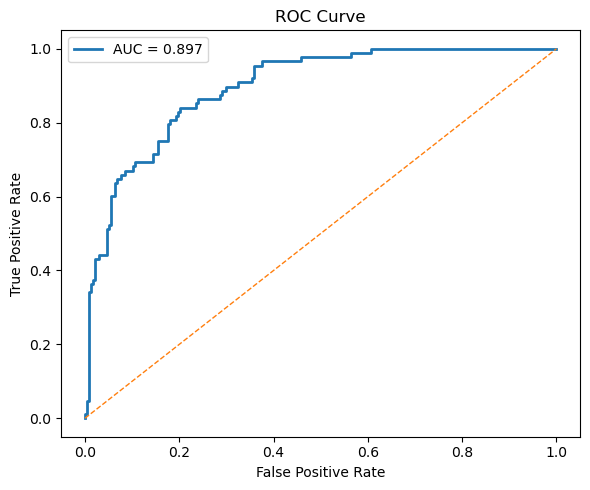

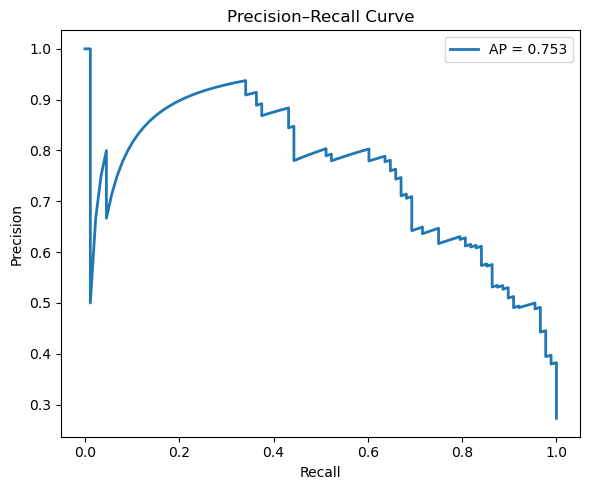

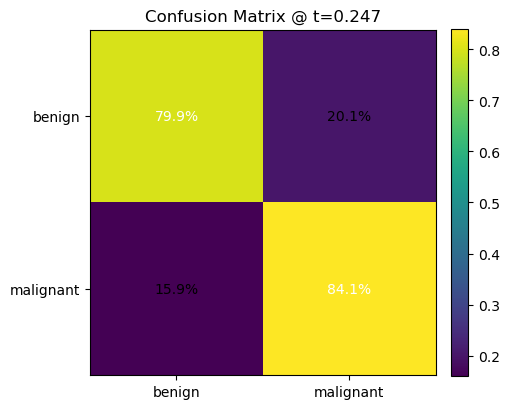

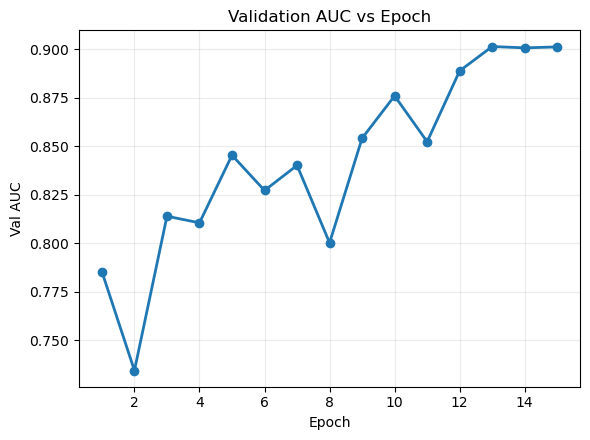

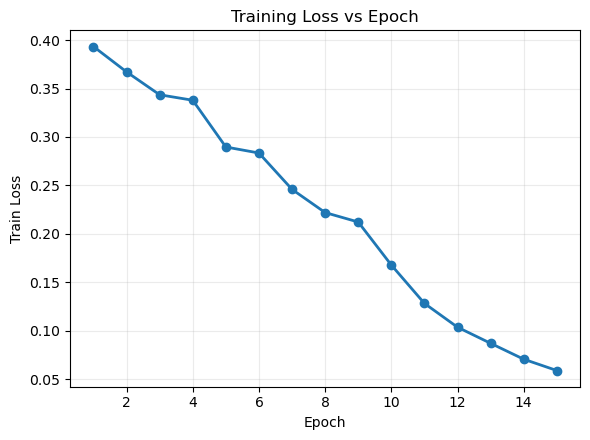

In [10]:
# ===========================================
# 10 — Visualizations: ROC, PR, CM, Training Curves
# ===========================================

from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

# ---- 1) ROC Curve ----
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc_score(y_true, y_prob):.3f}")
plt.plot([0, 1], [0, 1], ls="--", lw=1)  # diagonal = random chance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# ---- 2) Precision–Recall Curve ----
prec, rec, _ = precision_recall_curve(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, lw=2, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()

# ---- 3) Confusion Matrix (row-normalized) ----
cm_norm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True).clip(min=1)
fig, ax = plt.subplots(figsize=(5.2, 4.8))
im = ax.imshow(cm_norm, interpolation="nearest")
ax.set_title(f"Confusion Matrix @ t={best_t:.3f}")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["benign", "malignant"])
ax.set_yticklabels(["benign", "malignant"])

# Annotate each cell with % value
for (i, j), val in np.ndenumerate(cm_norm):
    ax.text(j, i, f"{val*100:.1f}%", ha="center", va="center",
            color="white" if val > 0.5 else "black")

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# ---- 4) Training History (if available) ----
if 'history' in globals() and len(history) > 0:
    epochs = [h["epoch"] for h in history]
    aucs   = [h["auc"]   for h in history]
    losses = [h["loss"]  for h in history]

    # Validation AUC curve
    plt.figure(figsize=(6, 4.5))
    plt.plot(epochs, aucs, lw=2, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Val AUC")
    plt.title("Validation AUC vs Epoch")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

    # Training loss curve
    plt.figure(figsize=(6, 4.5))
    plt.plot(epochs, losses, lw=2, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Train Loss")
    plt.title("Training Loss vs Epoch")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()
else:
    print("No `history` found — skipping training curves.")


## Results Summary — ConvNeXtV2-Tiny + Metadata (CBIS-DDSM crops)

**Overall discrimination**
- **ROC-AUC:** **0.897** → the model separates benign vs. malignant well (far from chance).
- **PR-AP:** **0.753** → strong precision–recall trade-off given class imbalance.

**Operating point (threshold tuning)**
- Tuned for best **F1** at **t = 0.247** (vs. default 0.50).
- At this threshold:
  - **Accuracy:** **0.811**
  - **Balanced Accuracy:** **0.820**
  - **Sensitivity (TPR):** **0.841** (recall for malignant)
  - **Specificity (TNR):** **0.799** (recall for benign)
  - **Precision (PPV):** **0.612**
  - **NPV:** **0.930**
  - **F1:** **0.708**
  - **MCC:** **0.589**

**Confusion matrix @ t = 0.247 (N = 322)**
- **TN = 187**, **FP = 47**, **FN = 14**, **TP = 74**  
  → The model misses **14** malignant cases (FN) and raises **47** false alarms (FP).

**What the plots show**
1. **ROC curve (AUC ≈ 0.897):** The curve hugs the top-left, indicating strong ranking ability across thresholds.  
2. **Precision–Recall curve (AP ≈ 0.753):** Precision stays reasonably high into mid-recall regions; expected drop at very high recall due to class imbalance.  
3. **Confusion matrix (row-normalized) @ t = 0.247:** Per-class recall ≈ **80%** (benign) and **84%** (malignant).  
4. **Training dynamics:**  
   - **Val AUC** climbs to ≈ **0.90** over 15 epochs.  
   - **Train loss** decreases steadily without instability → no obvious overfitting within this budget.

**Interpretation**
- The tuned operating point **prioritizes sensitivity** (catching malignant cases) with a **modest precision** (more false positives).  
- **High NPV (0.93)** means negative predictions are reliable—useful for **ruling out** malignancy in a screening workflow.  
- Compared to the default 0.5 threshold (**acc=0.817, F1=0.691**), tuning to **t=0.247** slightly lowers accuracy (0.811) but **improves F1 (0.708)** and **recall for malignant**, which is a sensible trade-off for screening.



In [25]:
# %%
# ===========================================
# Cell 11 — XAI Helpers (SHAP & LIME) — ConvNeXtV2 + metadata
# ===========================================
import os, warnings, numpy as np
import torch, torch.nn as nn
from PIL import Image
import cv2

warnings.filterwarnings("ignore", category=UserWarning)

# NumPy 2.0 shim for older SHAP versions
if not hasattr(np, "obj2sctype"):
    np.obj2sctype = lambda obj: np.dtype(obj).type

# Optional deps
try:
    import shap
except Exception:
    shap = None
    print("Note: SHAP not available. `pip install shap` to enable.")

try:
    from lime import lime_image
except Exception:
    lime_image = None
    print("Note: LIME not available. `pip install lime` to enable.")

try:
    from skimage.segmentation import slic, mark_boundaries
except Exception:
    slic = None
    mark_boundaries = None

# ----- pull globals from earlier cells -----
assert "model_best" in globals(), "model_best not found."
model_best.eval()
DEVICE        = globals().get("DEVICE", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
ROOT_DIR      = globals()["ROOT_DIR"]
val_df        = globals()["val_df"]
val_tf        = globals()["val_tf"]
val_loader    = globals()["val_loader"]
IMAGENET_MEAN = globals().get("IMAGENET_MEAN", (0.485, 0.456, 0.406))
IMAGENET_STD  = globals().get("IMAGENET_STD",  (0.229, 0.224, 0.225))

# ----- helpers -----
def meta_from_row(row):
    return torch.tensor([
        float(row["laterality_LEFT"]), float(row["laterality_RIGHT"]),
        float(row["view_CC"]), float(row["view_MLO"])
    ], dtype=torch.float32)

def preprocess_to_tensor(arr_uint8):
    out = val_tf(image=arr_uint8)["image"]
    if out.ndim == 3 and out.shape[0] == 1:  # gray->3ch guard
        out = out.repeat(3, 1, 1)
    return out

def load_raw_rgb_from_idx(idx):
    # idx can be positional or a true df index
    row = val_df.loc[idx] if idx in val_df.index else val_df.iloc[int(idx)]
    p = os.path.join(ROOT_DIR, str(row["yolo_cropped_image_path"]).replace("\\", os.sep))
    im = Image.open(p).convert("L")
    arr = np.stack([np.array(im)]*3, axis=2).astype(np.uint8)  # gray→RGB
    return arr, row

# LIME classifier wrapper (freezes per-sample meta)
def make_lime_predict_fn(row, model):
    meta_const = meta_from_row(row).to(DEVICE).unsqueeze(0)  # (1,4)
    def predict(images):
        xs = []
        for img in images:
            if img.ndim == 3 and img.shape[2] == 3:
                xs.append(preprocess_to_tensor(img))
            else:
                img3 = np.stack([img]*3, axis=2).astype(np.uint8)
                xs.append(preprocess_to_tensor(img3))
        x = torch.stack(xs, dim=0).to(DEVICE, non_blocking=True)
        m = meta_const.expand(x.size(0), -1)
        with torch.no_grad():
            logits = model(x, m)
            probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()
        return np.stack([1.0 - probs, probs], axis=1)  # [p0, p1]
    return predict

# SHAP: wrap to return probabilities and accept (x, meta) tuple
class ProbWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model.eval()
    def forward(self, x_and_meta):
        x, meta = x_and_meta
        logits = self.model(x, meta)              # (B,1)
        probs  = torch.sigmoid(logits).squeeze(1) # (B,)
        return probs

# pick up to 2 positions (one benign, one malignant if possible)
y_vals = val_df["label"].to_numpy()
ben_pos = np.where(y_vals == 0)[0][:1]
mal_pos = np.where(y_vals == 1)[0][:1]
chosen_pos = np.concatenate([ben_pos, mal_pos]) if (len(ben_pos) and len(mal_pos)) else np.arange(min(2, len(val_df)))
print("Chosen positions for XAI:", chosen_pos.tolist())


Chosen positions for XAI: [1, 0]


## Grad-CAM++: Visual Explanations with Metadata-Aware Inference

I use **Grad-CAM++** to highlight the image regions that most influence the model’s prediction, while keeping the **metadata fixed** for the current batch.

### Why Grad-CAM++?
Grad-CAM++ improves over vanilla Grad-CAM by better handling multiple contributing regions and producing sharper attributions using higher-order gradient terms.

### Setup
- I wrap the trained model with a small adapter so that `forward(x)` also injects the **metadata** vector held in the wrapper.
- I locate the **last convolutional layer** in the image backbone as the attribution target. This layer has the right spatial granularity for localization.

### Computation Outline
1. **Forward pass** to get the positive-class logit \( y \) for each image (or the ground-truth class, as chosen here).
2. **Hooks** capture the feature maps \( A \in \mathbb{R}^{C \times H \times W} \) and their gradients \( dY = \partial y / \partial A \).
3. Grad-CAM++ **weights** are computed channel-wise using second- and third-order gradient terms:

$$
\alpha_{c, i, j}
=
\frac{\left(\frac{\partial y}{\partial A_{c, i, j}}\right)^2}
{2 \left(\frac{\partial y}{\partial A_{c, i, j}}\right)^2
+ A_{c, i, j} \left(\frac{\partial^2 y}{\partial A_{c, i, j}^2}\right) + \varepsilon}
$$

The channel weights are then:

$$
w_c = \sum_{i, j} \alpha_{c, i, j} \cdot \text{ReLU}\!\left(\frac{\partial y}{\partial A_{c, i, j}}\right)
$$

4. The final **class activation map** is a ReLU’ed weighted sum of feature maps:

$$
\mathrm{CAM}(i,j) = \text{ReLU}\!\left(\sum_c w_c \, A_{c, i, j}\right)
$$

I normalize CAMs to \([0,1]\) and overlay them on the original image for visualization.

### Interpretation Notes
- **Bright (hot) regions** indicate areas that **increase** the logit for the target class (malignant or benign, depending on the target).
- Here I set the target to the **ground-truth class** via `BinaryClassifierOutputTarget`, which is useful for auditing whether the model focuses on plausible regions.
- Because the model fuses **metadata** (laterality, view), the visual map shows *image* evidence only; non-image features influence the logit but do not appear spatially.

### Caveats
- Grad-CAM highlights **correlated** evidence, not causal features.
- The chosen layer matters: too early → noisy; too late → overly coarse.
- Always complement CAMs with quantitative metrics and, when possible, expert review.

This step adds **interpretability** to the classifier by revealing *where* the network is “looking” when making a decision.


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


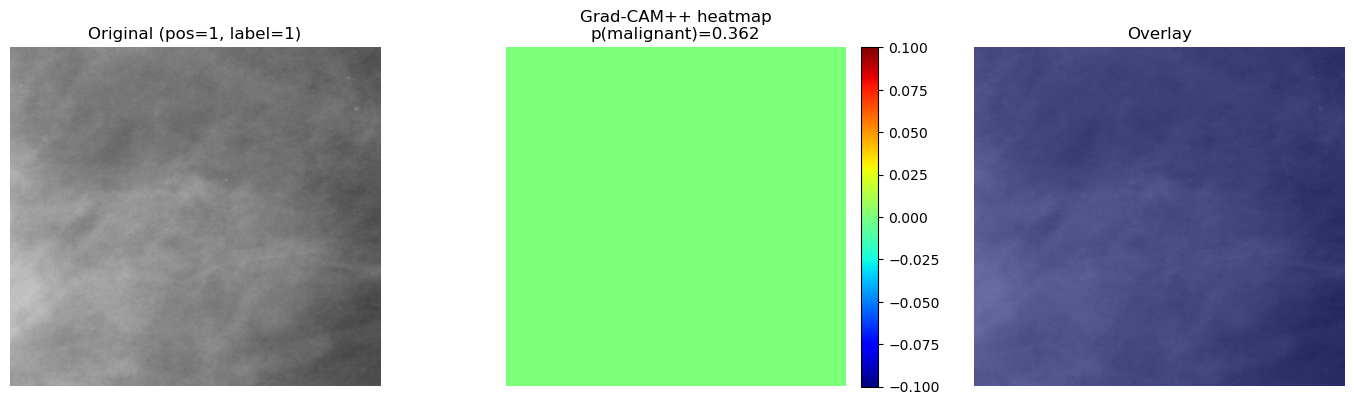

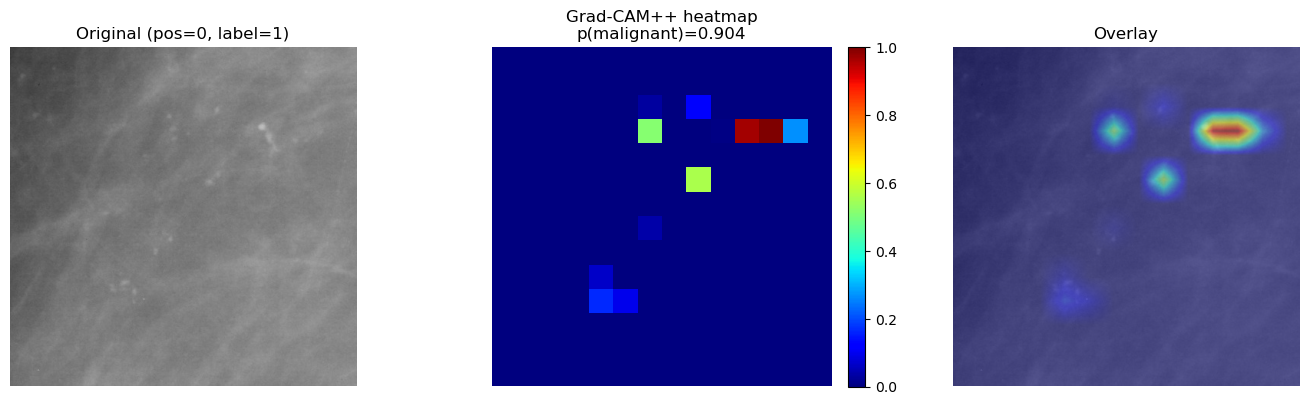

Grad-CAM++ target layer used: stages.3.blocks.2.conv_dw


In [26]:
# %%
# ===========================================
# Cell 13 — Grad-CAM++ (ConvNeXtV2 + metadata) — robust
# ===========================================
import torch, torch.nn.functional as F
import numpy as np, matplotlib.pyplot as plt
from matplotlib import cm

def find_last_conv2d(module: nn.Module):
    """Find the last nn.Conv2d inside the image backbone (ConvNeXtV2-safe)."""
    last = None
    for name, m in module.named_modules():
        if isinstance(m, nn.Conv2d):
            last = (name, m)
    if last is None:
        raise RuntimeError("No nn.Conv2d layer found for Grad-CAM. Try an earlier layer by name.")
    return last  # (name, module)

class GradCAMPP:
    """
    Grad-CAM++ for your (x, meta)->logit model.
    - model_with_meta: your model (returns raw logit)
    - meta_tensor_fixed: (1,4) tensor with the sample's metadata
    """
    def __init__(self, model_with_meta, meta_tensor_fixed, target_layer_name=None):
        self.model = model_with_meta.eval()
        self.meta = meta_tensor_fixed  # (1,4) on DEVICE

        if target_layer_name is None:
            self.tgt_name, self.tgt_layer = find_last_conv2d(self.model.base)  # <-- ConvNeXt backbone
        else:
            self.tgt_name = target_layer_name
            self.tgt_layer = dict([*self.model.base.named_modules()])[target_layer_name]

        self.activations = None
        self.gradients = None

        def f_hook(m, inp, out):
            self.activations = out.detach()             # (B,C,H,W)
        def b_hook(m, gin, gout):
            self.gradients = gout[0].detach()           # (B,C,H,W)

        # register hooks robustly
        try:
            self.tgt_layer.register_full_backward_hook(b_hook)
        except Exception:
            self.tgt_layer.register_backward_hook(lambda m, gin, gout: b_hook(m, gin, gout))
        self.tgt_layer.register_forward_hook(f_hook)

    def forward_logit(self, x):
        return self.model(x, self.meta.expand(x.size(0), -1))  # (B,1)

    def __call__(self, x):
        x.requires_grad_(True)
        logit = self.forward_logit(x)                   # (1,1)
        self.model.zero_grad(set_to_none=True)
        with torch.enable_grad():
            logit[0,0].backward(retain_graph=True)

        A  = self.activations
        dY = self.gradients
        if A is None or dY is None:
            raise RuntimeError(f"Grad-CAM hooks failed (target='{self.tgt_name}').")

        # Grad-CAM++ weights
        dY2  = dY ** 2
        dY3  = dY ** 3
        sumA = torch.sum(A, dim=(2,3), keepdim=True)
        eps  = 1e-8
        alpha   = dY2 / (2.0 * dY2 + sumA * dY3 + eps)          # (B,C,H,W)
        weights = torch.sum(alpha * F.relu(dY), dim=(2,3))      # (B,C)

        cam = torch.sum(weights[:, :, None, None] * A, dim=1)   # (B,H,W)
        cam = F.relu(cam)
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)
        prob = float(torch.sigmoid(logit)[0,0].item())
        return cam[0].detach().cpu().numpy(), prob

def overlay_cam_on_image(raw_uint8, cam_01, alpha=0.45, cmap_name="jet"):
    h, w = raw_uint8.shape[:2]
    if cam_01.shape[:2] != (h, w):
        cam_01 = cv2.resize(cam_01, (w, h))
    heatmap = cm.get_cmap(cmap_name)(cam_01)[..., :3]
    img = raw_uint8.astype(np.float32) / 255.0
    return np.clip((1 - alpha) * img + alpha * heatmap, 0, 1)

# ---- run Grad-CAM++ on the chosen positions ----
for pos in chosen_pos:
    raw, row = load_raw_rgb_from_idx(pos)                   # uint8 HxWx3
    x = preprocess_to_tensor(raw).unsqueeze(0).to(DEVICE)   # (1,3,H,W)
    meta_fixed = meta_from_row(row).to(DEVICE).unsqueeze(0) # (1,4)

    campp = GradCAMPP(model_best, meta_fixed, target_layer_name=None)
    cam, p_malignant = campp(x)
    overlay = overlay_cam_on_image(raw, cam, alpha=0.45, cmap_name="jet")

    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1)
    plt.title(f"Original (pos={int(pos)}, label={int(row['label'])})")
    plt.imshow(raw); plt.axis("off")

    plt.subplot(1,3,2)
    plt.title(f"Grad-CAM++ heatmap\np(malignant)={p_malignant:.3f}")
    plt.imshow(cam, cmap="jet"); plt.colorbar(fraction=0.046, pad=0.04); plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Overlay")
    plt.imshow(overlay); plt.axis("off")
    plt.tight_layout(); plt.show()

print("Grad-CAM++ target layer used:", campp.tgt_name)


## LIME Explanations for Images + Metadata

I use **LIME (Local Interpretable Model-agnostic Explanations)** to highlight *image regions* (superpixels) that most influence the model’s predicted probability of **malignancy**, while keeping the **exam metadata** fixed for the current sample.

### Model I explain
I wrap the trained model with a small predictor:

- **Input:** an RGB image \( \mathbf{x} \in [0,255]^{H \times W \times 3} \) (uint8) and a **fixed** metadata vector \( \mathbf{m} \in \mathbb{R}^{4} \) (`laterality_LEFT`, `laterality_RIGHT`, `view_CC`, `view_MLO`) for the sample.
- **Output:** class probabilities \([\,p(\text{benign}),\; p(\text{malignant})\,]\), where

$$
\hat{p} \;=\; \sigma(z) \;=\; \frac{1}{1 + e^{-z}},\quad
p(\text{malignant}) \;=\; \hat{p},\quad
p(\text{benign}) \;=\; 1 - \hat{p}.
$$

> LIME calls this predictor many times on perturbed versions of \( \mathbf{x} \); \( \mathbf{m} \) is held constant so the explanation reflects *image evidence* only.

### How LIME works (intuition)
1. **Superpixel segmentation:** Partition the image into contiguous regions (“superpixels”).
2. **Perturbations:** Randomly turn superpixels on/off to create many modified images.
3. **Local surrogate:** Fit a simple, locally weighted model to approximate the classifier’s behavior near the original image.
4. **Importance weights:** Superpixels that strongly shift \( p(\text{malignant}) \) get higher positive (red) or negative (blue) importance.

### Configuration
- **Segmentation:** SLIC (or a robust fallback) with about **100–150** superpixels and moderate **compactness**.
- **Samples:** about **800–1000** perturbed images per explanation (tunable for speed vs. fidelity).
- **Metadata:** The 4 metadata indicators are **frozen** for the target image to isolate pixel-level effects.

### What the visualizations show
1. **LIME — positive-only (malignant):** Highlights superpixels that *increase* \( p(\text{malignant}) \) when present.
2. **LIME — positive + negative:** Shows both malignant-supporting (positive) and benign-supporting (negative) regions, clarifying trade-offs.



100%|██████████| 800/800 [02:43<00:00,  4.90it/s]


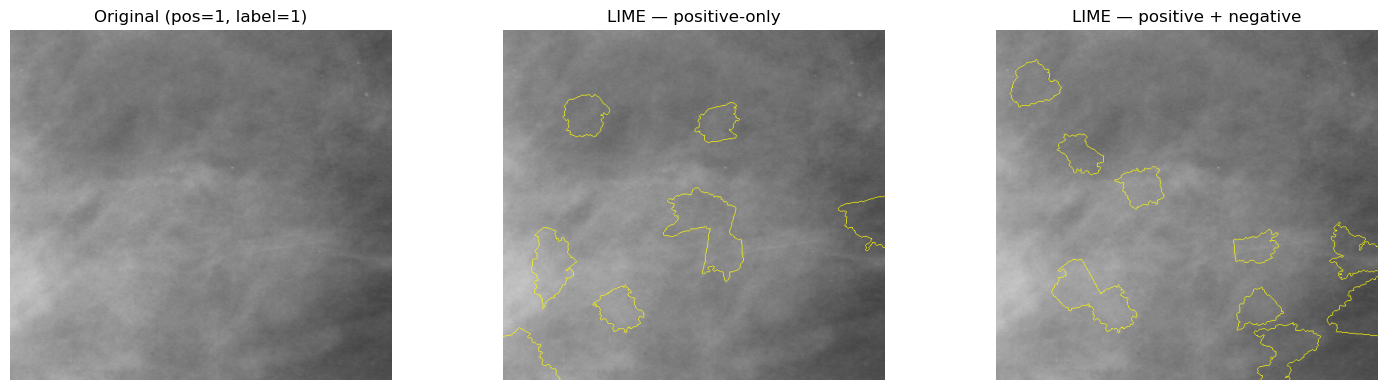

100%|██████████| 800/800 [02:39<00:00,  5.01it/s]


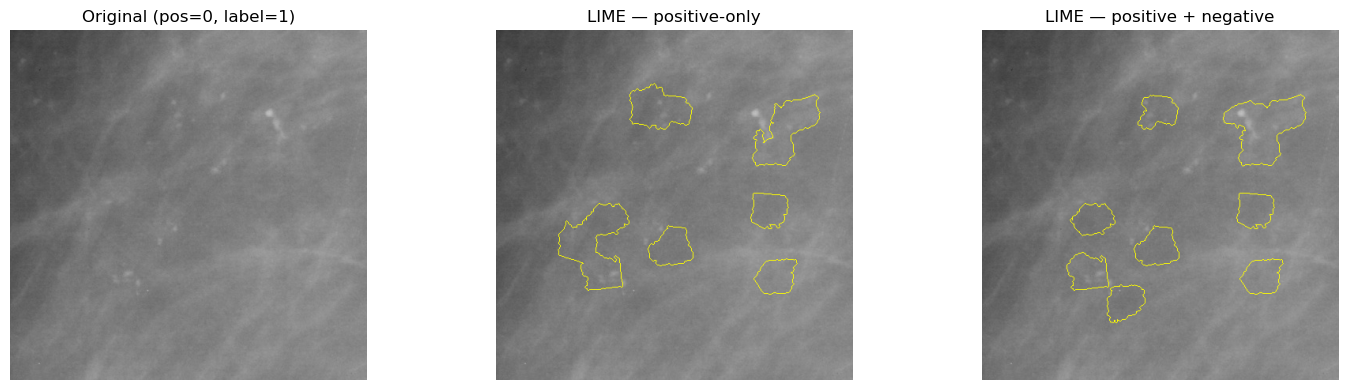

In [27]:
# %%
# ===========================================
# Cell 12 — LIME Image Explanations (ConvNeXtV2 + meta)
# ===========================================
import numpy as np
import matplotlib.pyplot as plt

def _segmentation_fn_factory(n_segments=120, compactness=10.0):
    # Prefer skimage.slic if available
    if slic is not None:
        def seg_slic(img):
            return slic(img.astype(np.float32)/255.0, n_segments=int(n_segments),
                        compactness=float(compactness), start_label=0, sigma=1)
        return seg_slic
    # simple grid fallback (never None)
    def seg_grid(img):
        H, W = img.shape[:2]
        g = int(np.sqrt(max(1, n_segments)))
        gh = max(1, H // g)
        gw = max(1, W // g)
        yy = (np.arange(H)//gh)[:, None]
        xx = (np.arange(W)//gw)[None, :]
        return (yy * g + xx).astype(np.int32)
    return seg_grid

if lime_image is None:
    print("LIME not installed; skipping LIME cell.")
else:
    explainer_lime = lime_image.LimeImageExplainer()
    seg_fn = _segmentation_fn_factory(n_segments=120, compactness=10.0)

    for pos in chosen_pos:  # POSITIONS, not labels
        raw, row = load_raw_rgb_from_idx(pos)
        predict_fn = make_lime_predict_fn(row, model_best)

        explanation = explainer_lime.explain_instance(
            raw,
            predict_fn,
            top_labels=2,
            hide_color=0,
            num_samples=800,     # memory-friendly
            segmentation_fn=seg_fn,
            random_seed=42
        )

        # malignant label if present, else top
        label_choice = 1 if 1 in explanation.top_labels else int(explanation.top_labels[0])

        _, mask_pos = explanation.get_image_and_mask(
            label=label_choice, positive_only=True, num_features=10, hide_rest=False
        )
        _, mask_both = explanation.get_image_and_mask(
            label=label_choice, positive_only=False, num_features=10, hide_rest=False
        )

        img01 = raw.astype(np.float32) / 255.0

        plt.figure(figsize=(15,4))
        plt.subplot(1,3,1)
        plt.title(f"Original (pos={int(pos)}, label={int(row['label'])})")
        plt.imshow(raw); plt.axis("off")

        plt.subplot(1,3,2)
        plt.title("LIME — positive-only")
        if mark_boundaries is not None:
            plt.imshow(mark_boundaries(img01, (mask_pos>0).astype(np.int32)))
        else:
            ov = img01.copy(); ov[mask_pos==0] *= 0.4; plt.imshow(ov)
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.title("LIME — positive + negative")
        if mark_boundaries is not None:
            plt.imshow(mark_boundaries(img01, (mask_both!=0).astype(np.int32)))
        else:
            ov = img01.copy(); ov[mask_both==0] *= 0.4; plt.imshow(ov)
        plt.axis("off")

        plt.tight_layout(); plt.show()
